In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
from IPython.display import HTML
from matplotlib.animation import PillowWriter

In [3]:
# === Load and prepare data ===
log_file_path = 'hxx.log'
df_log = pd.read_csv(log_file_path)

In [4]:
# Clip time range for true path
start_time = df_log['time'].iloc[0] + 70
end_time = start_time + 30
df_clipped_true = df_log[(df_log['time'] >= start_time) & (df_log['time'] <= end_time)].reset_index(drop=True)

# Clip time range for the reference path
start_time = df_log['time'].iloc[0] + 70 - 0.8
end_time = start_time + 15 + 0.8
df_clipped_ref = df_log[(df_log['time'] >= start_time) & (df_log['time'] <= end_time)].reset_index(drop=True)

# Clip time range for black dot path
start_time = df_log['time'].iloc[0] + 70 - 0.6
end_time = start_time + 30 + 0.6
df_clipped_black_dot = df_log[(df_log['time'] >= start_time) & (df_log['time'] <= end_time)].reset_index(drop=True)

In [5]:
# Set skip factor
skip_factor = 1

# Adjust battery offset
battery_adj = df_clipped_true['z'].max() - df_clipped_true['z_ref'].max()


In [6]:
# Extract data true path
df_clipped_true = df_clipped_true.iloc[::skip_factor].reset_index(drop=True)
time_vals = df_clipped_true['time'].values
x = df_clipped_true['x'].values
y = df_clipped_true['y'].values
z = -1 * (df_clipped_true['z']).values + battery_adj

# Extract data reference path
df_clipped_ref = df_clipped_ref.iloc[::skip_factor].reset_index(drop=True)
x_ref = df_clipped_ref['x_ref'].values
y_ref = df_clipped_ref['y_ref'].values
z_ref = -1 * df_clipped_ref['z_ref'].values

# Extract data black dot path
df_clipped_black_dot = df_clipped_black_dot.iloc[::skip_factor].reset_index(drop=True)
x_ref_blackdot = df_clipped_black_dot['x_ref'].values
y_ref_blackdot = df_clipped_black_dot['y_ref'].values
z_ref_blackdot = -1 * df_clipped_black_dot['z_ref'].values


# Estimate new dt
dt_vals = np.diff(time_vals, prepend=time_vals[0])
interval_ms = int(np.mean(dt_vals) * 1000)

In [7]:
# Constants
INCHES_TO_METERS = 0.0254
CAMERA_X_INCHES = -112  # Camera is 112 inches left of MoCap origin
CAMERA_Z_INCHES = 48   # Camera is 48 inches above MoCap origin (NED Z is inverted)
CAMERA_X = CAMERA_X_INCHES * INCHES_TO_METERS
CAMERA_Z = CAMERA_Z_INCHES * INCHES_TO_METERS

# --- Data Transformation ---
# MoCap NED (X: forward, Y: right, Z: down) → iPhone view (X: forward, Y: right, Z: up)

# reference path transform
x_plot_ref = x_ref - CAMERA_X  # Shift X to camera-relative coords
y_plot_ref = y_ref             # Y remains right
z_plot_ref = z_ref + CAMERA_Z # Invert Z (NED → ENU) and adjust for camera height

# true path transform
x_plot_true = x - CAMERA_X  # Shift X to camera-relative coords
y_plot_true = y             # Y remains right
z_plot_true = z + CAMERA_Z # Invert Z (NED → ENU) and adjust for camera height

# black dot path transform
x_plot_blackdot = x_ref_blackdot - CAMERA_X  # Shift X to camera-relative coords
y_plot_blackdot = y_ref_blackdot             # Y remains right
z_plot_blackdot = z_ref_blackdot + CAMERA_Z # Invert Z (NED → ENU) and adjust for camera height


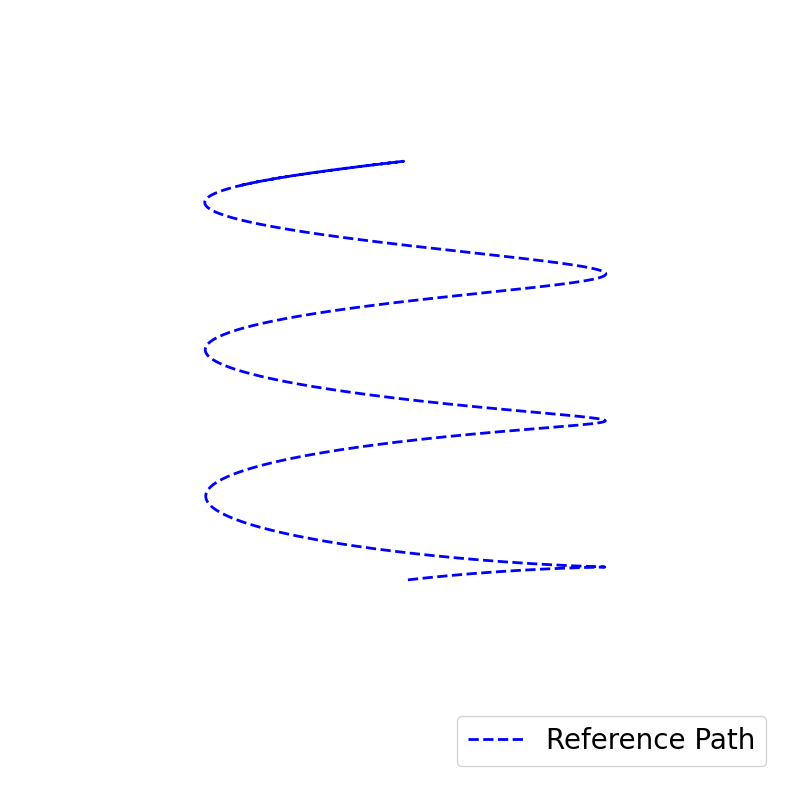

In [42]:
# Create figure with transparent background
fig = plt.figure(figsize=(10, 8), facecolor='none')
ax = fig.add_subplot(111, projection='3d')

# --- Plot Settings (Fully Transparent) ---
ax.set_facecolor('none')
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))

# --- Plot Reference Path (Dashed Blue) ---
ax.plot(-x_plot_ref, y_plot_ref, z_plot_ref, 'b--', linewidth=2, label='Reference Path')
# --- Plot True Path (Solid Red) ---
# ax.plot(x_plot_true, y_plot_true, z_plot_true, 'r-', linewidth=2, label='True Path')

# --- Set View to Match iPhone 13 Pro Max Perspective ---
# Typical phone angle: slightly downward, facing forward
elevation = 4
ax.view_init(elev=elevation, azim=0)  # Adjust as needed
# ax.dist = 10
# --- Equal Aspect Ratio (Prevents Distortion) ---
ax.set_box_aspect([1, 1, 1])

# --- Add Legend ---
ax.legend(loc='lower right', fontsize=20)

plt.tight_layout()
plt.show()

In [30]:
# %%
# Create NEW figure for animation
fig_anim = plt.figure(figsize=(10, 8), facecolor='none')
ax_anim = fig_anim.add_subplot(111, projection='3d')

# --- Animation Plot Settings ---
ax_anim.set_facecolor('none')
[ax_anim.axis('off') for axis in [ax_anim.xaxis, ax_anim.yaxis, ax_anim.zaxis]]
ax_anim.grid(False)

# --- Plot Static Reference Path ---
ax_anim.plot(-x_plot_ref, y_plot_ref, z_plot_ref, 'b--', linewidth=2, label='Reference Path')

# --- Initialize Animated Elements ---
# ref_dot, = ax_anim.plot([], [], [], 'ko', markersize=8, label='Reference Position')
true_path, = ax_anim.plot([], [], [], 'r-', linewidth=2, label='True Path')

# --- Set View and Aspect Ratio ---
# ax_anim.view_init(elev=elevation, azim=0)
# ax_anim.set_box_aspect([1, 1, 1])
# ax_anim.legend(loc='lower right', fontsize=19)
# --- Set View and Aspect Ratio ---
ax_anim.view_init(elev=elevation, azim=0)
ax_anim.set_box_aspect([1, 1, 1])

# --- Add Legend with adjusted position ---
ax_anim.legend(loc='center left', bbox_to_anchor=(0.71, 0.90), fontsize=26)
plt.tight_layout()  # This helps prevent legend from being cut off



# --- Ensure all arrays are same length ---
min_length = min(len(x_plot_true), len(y_plot_true), len(z_plot_true),
               len(x_plot_blackdot), len(y_plot_blackdot), len(z_plot_blackdot))
x_plot_true = x_plot_true[:min_length]
y_plot_true = y_plot_true[:min_length]
z_plot_true = z_plot_true[:min_length]
x_plot_blackdot = x_plot_blackdot[:min_length]
y_plot_blackdot = y_plot_blackdot[:min_length]
z_plot_blackdot = z_plot_blackdot[:min_length]

# --- Animation Functions ---
def init():
    # Initialize with empty numpy arrays
    true_path.set_data(np.array([]), np.array([]))
    true_path.set_3d_properties(np.array([]))
    # ref_dot.set_data(np.array([]), np.array([]))
    # ref_dot.set_3d_properties(np.array([]))
    return true_path#, ref_dot

def update(frame):
    # Update true path with numpy arrays
    true_path.set_data(np.array(-x_plot_true[:frame+1]), np.array(y_plot_true[:frame+1]))
    true_path.set_3d_properties(np.array(z_plot_true[:frame+1]))
    
    # Update reference dot with numpy arrays
    # ref_dot.set_data(np.array([x_plot_blackdot[frame]]), np.array([y_plot_blackdot[frame]]))
    # ref_dot.set_3d_properties(np.array([z_plot_blackdot[frame]]))
    
    return true_path#, ref_dot

# --- Create Animation ---
ani = animation.FuncAnimation(
    fig_anim, 
    update, 
    frames=min_length,
    init_func=init, 
    blit=False, 
    interval=interval_ms,
    repeat=False
)

# --- Save as GIF ---
print(f"Creating animation with {min_length} frames...")
gif_writer = PillowWriter(fps=30)
ani.save('drone_animation.gif', 
            writer=gif_writer,
            dpi=100,
            progress_callback=lambda i, n: print(f"\rSaving frame {i+1}/{n}", end=''))
print("\nAnimation saved successfully as 'drone_animation.gif'")
# try:
#     print(f"Creating animation with {min_length} frames...")
#     gif_writer = PillowWriter(fps=30)
#     ani.save('drone_animation.gif', 
#              writer=gif_writer,
#              dpi=100,
#              progress_callback=lambda i, n: print(f"\rSaving frame {i+1}/{n}", end=''))
#     print("\nAnimation saved successfully as 'drone_animation.gif'")
# except Exception as e:
#     print(f"\nError saving animation: {str(e)}")

plt.close(fig_anim)

Creating animation with 1809 frames...
Saving frame 1809/1809
Animation saved successfully as 'drone_animation.gif'


In [10]:
# # %%
# # Create NEW figure for animation
# fig_anim = plt.figure(figsize=(10, 8), facecolor='none')
# ax_anim = fig_anim.add_subplot(111, projection='3d')

# # --- Animation Plot Settings ---
# ax_anim.set_facecolor('none')
# [ax_anim.axis('off') for axis in [ax_anim.xaxis, ax_anim.yaxis, ax_anim.zaxis]]
# ax_anim.grid(False)

# # --- Plot Static Reference Path ---
# ax_anim.plot(x_plot_ref, y_plot_ref, z_plot_ref, 'b--', linewidth=2, label='Reference Path')

# # --- Initialize Animated Elements ---
# # For the black dot, we'll use scatter plot which doesn't leave trails
# ref_dot = ax_anim.scatter([], [], [], c='k', s=50, label='Reference Position')
# true_path, = ax_anim.plot([], [], [], 'r-', linewidth=2, label='True Path')

# # --- Set View and Aspect Ratio ---
# ax_anim.view_init(elev=-20, azim=0)
# ax_anim.set_box_aspect([1, 1, 1])
# ax_anim.legend(loc='upper right', fontsize=12)

# # --- Ensure all arrays are same length ---
# min_length = min(len(x_plot_true), len(y_plot_true), len(z_plot_true),
#                len(x_plot_blackdot), len(y_plot_blackdot), len(z_plot_blackdot))
# x_plot_true = x_plot_true[:min_length]
# y_plot_true = y_plot_true[:min_length]
# z_plot_true = z_plot_true[:min_length]
# x_plot_blackdot = x_plot_blackdot[:min_length]
# y_plot_blackdot = y_plot_blackdot[:min_length]
# z_plot_blackdot = z_plot_blackdot[:min_length]

# # --- Animation Functions ---
# def init():
#     # Initialize with empty numpy arrays
#     true_path.set_data(np.array([]), np.array([]))
#     true_path.set_3d_properties(np.array([]))
#     ref_dot._offsets3d = (np.array([]), np.array([]), np.array([]))
#     return true_path, ref_dot

# def update(frame):
#     # Update true path (growing red line)
#     true_path.set_data(np.array(x_plot_true[:frame+1]), np.array(y_plot_true[:frame+1]))
#     true_path.set_3d_properties(np.array(z_plot_true[:frame+1]))
    
#     # Update reference dot (single point at current position)
#     ref_dot._offsets3d = (np.array([x_plot_blackdot[frame]]), 
#                          np.array([y_plot_blackdot[frame]]), 
#                          np.array([z_plot_blackdot[frame]]))
    
#     return true_path, ref_dot

# # --- Create Animation ---
# ani = animation.FuncAnimation(
#     fig_anim, 
#     update, 
#     frames=min_length,
#     init_func=init, 
#     blit=False, 
#     interval=interval_ms,
#     repeat=False
# )

# # --- Save as GIF ---
# try:
#     print(f"Creating animation with {min_length} frames...")
#     gif_writer = PillowWriter(fps=30)
#     ani.save('drone_animation.gif', 
#              writer=gif_writer,
#              dpi=100,
#              progress_callback=lambda i, n: print(f"\rSaving frame {i+1}/{n}", end=''))
#     print("\nAnimation saved successfully as 'drone_animation.gif'")
# except Exception as e:
#     print(f"\nError saving animation: {str(e)}")

# plt.close(fig_anim)

In [11]:
# # %%
# # Create NEW figure for animation
# fig_anim = plt.figure(figsize=(10, 8), facecolor='none')
# ax_anim = fig_anim.add_subplot(111, projection='3d')

# # --- Animation Plot Settings ---
# ax_anim.set_facecolor('none')
# [ax_anim.axis('off') for axis in [ax_anim.xaxis, ax_anim.yaxis, ax_anim.zaxis]]
# ax_anim.grid(False)

# # --- Plot Static Reference Path ---
# ax_anim.plot(x_plot_ref, y_plot_ref, z_plot_ref, 'b--', linewidth=2, label='Reference Path')

# # --- Initialize Animated Elements ---
# # Use plot for the black dot to avoid trail artifacts
# ref_dot, = ax_anim.plot([], [], [], 'ko', markersize=5, label='Reference Dot')
# true_path, = ax_anim.plot([], [], [], 'r-', linewidth=2, label='True Path')

# # --- Set View and Aspect Ratio ---
# ax_anim.view_init(elev=-20, azim=0)
# ax_anim.set_box_aspect([1, 1, 1])
# ax_anim.legend(loc='upper right', fontsize=12)

# # --- Ensure all arrays are same length ---
# min_length = min(len(x_plot_true), len(y_plot_true), len(z_plot_true),
#                  len(x_plot_blackdot), len(y_plot_blackdot), len(z_plot_blackdot))
# x_plot_true = x_plot_true[:min_length]
# y_plot_true = y_plot_true[:min_length]
# z_plot_true = z_plot_true[:min_length]
# x_plot_blackdot = x_plot_blackdot[:min_length]
# y_plot_blackdot = y_plot_blackdot[:min_length]
# z_plot_blackdot = z_plot_blackdot[:min_length]

# # --- Animation Functions ---
# def init():
#     true_path.set_data(np.array([]), np.array([]))
#     true_path.set_3d_properties(np.array([]))
#     ref_dot.set_data(np.array([]), np.array([]))
#     ref_dot.set_3d_properties(np.array([]))
#     return true_path, ref_dot


# def update(frame):
#     # Update true path (growing red line)
#     true_path.set_data(np.array(x_plot_true[:frame+1]), np.array(y_plot_true[:frame+1]))
#     true_path.set_3d_properties(np.array(z_plot_true[:frame+1]))
    
#     # Update reference dot (only 1 point at a time, ensure numpy arrays)
#     ref_dot.set_data(np.array([x_plot_blackdot[frame]]), np.array([y_plot_blackdot[frame]]))
#     ref_dot.set_3d_properties(np.array([z_plot_blackdot[frame]]))
    
#     return true_path, ref_dot


# # --- Create Animation ---
# ani = animation.FuncAnimation(
#     fig_anim, 
#     update, 
#     frames=min_length,
#     init_func=init, 
#     blit=False, 
#     interval=interval_ms,
#     repeat=False
# )

# # --- Save as GIF ---
# print(f"Creating animation with {min_length} frames...")
# gif_writer = PillowWriter(fps=30)
# ani.save('drone_animation.gif', 
#          writer=gif_writer,
#          dpi=100,
#          progress_callback=lambda i, n: print(f"\rSaving frame {i+1}/{n}", end=''))
# print("\nAnimation saved successfully as 'drone_animation.gif'")

# plt.close(fig_anim)


In [12]:
# # %%
# # Create NEW figure for animation
# fig_anim = plt.figure(figsize=(10, 8), facecolor='none')
# ax_anim = fig_anim.add_subplot(111, projection='3d')

# # --- Animation Plot Settings ---
# ax_anim.set_facecolor('none')
# [ax_anim.axis('off') for axis in [ax_anim.xaxis, ax_anim.yaxis, ax_anim.zaxis]]
# ax_anim.grid(False)

# # --- Plot Static Reference Path ---
# ax_anim.plot(x_plot_ref, y_plot_ref, z_plot_ref, 'b--', linewidth=2, label='Reference Path')

# # --- Initialize Animated Elements ---
# # For the black dot, we'll use plot but only show one point at a time
# ref_dot, = ax_anim.plot([], [], [], 'ko', markersize=8, label='Reference Dot')
# true_path, = ax_anim.plot([], [], [], 'r-', linewidth=2, label='True Path')

# # --- Set View and Aspect Ratio ---
# ax_anim.view_init(elev=-20, azim=0)
# ax_anim.set_box_aspect([1, 1, 1])
# ax_anim.legend(loc='upper right', fontsize=12)

# # --- Ensure all arrays are same length ---
# min_length = min(len(x_plot_true), len(y_plot_true), len(z_plot_true),
#                len(x_plot_blackdot), len(y_plot_blackdot), len(z_plot_blackdot))
# x_plot_true = x_plot_true[:min_length]
# y_plot_true = y_plot_true[:min_length]
# z_plot_true = z_plot_true[:min_length]
# x_plot_blackdot = x_plot_blackdot[:min_length]
# y_plot_blackdot = y_plot_blackdot[:min_length]
# z_plot_blackdot = z_plot_blackdot[:min_length]

# # --- Animation Functions ---
# def init():
#     # Initialize with empty numpy arrays
#     true_path.set_data(np.array([]), np.array([]))
#     true_path.set_3d_properties(np.array([]))
#     ref_dot.set_data(np.array([]), np.array([]))
#     ref_dot.set_3d_properties(np.array([]))
#     return true_path, ref_dot

# def update(frame):
#     # Update true path (growing red line)
#     true_path.set_data(np.array(x_plot_true[:frame+1]), np.array(y_plot_true[:frame+1]))
#     true_path.set_3d_properties(np.array(z_plot_true[:frame+1]))
    
#     # Update reference dot (single point only)
#     # ref_dot.set_data(np.array([x_plot_blackdot[frame]]), np.array([y_plot_blackdot[frame]]))
#     # ref_dot.set_3d_properties(np.array([z_plot_blackdot[frame]]))
    
#     return true_path, ref_dot

# # --- Create Animation ---
# ani = animation.FuncAnimation(
#     fig_anim, 
#     update, 
#     frames=min_length,
#     init_func=init, 
#     blit=False, 
#     interval=interval_ms,
#     repeat=False
# )

# # --- Save as GIF ---
# print(f"Creating animation with {min_length} frames...")
# ani.save('drone_animation.gif', 
#             writer=PillowWriter(fps=30),
#             dpi=100,
#             progress_callback=lambda i, n: print(f"\rSaving frame {i+1}/{n}", end=''))
# print("\nAnimation saved successfully as 'drone_animation.gif'")


# plt.close(fig_anim)